In [19]:
# Import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# importing climate data including rainfall, Temperature, Relative humidity and Windspeed

df_Temp = pd.read_csv('Temperature-2010-2025-Monthly.csv')
df_Wind = pd.read_csv('Windspeed-2010-2025-Monthly.csv')
df_Hum = pd.read_csv('RHum-2010-2025-Monthly.csv')
df_rain = pd.read_csv('Rainfall-2010-2025-Monthly.csv')

In [21]:
# Importing incidence sheets into the notebook

df_1014 = pd.read_excel("2010-2014IPD-OPD-Deaths.xls", header=1)
df_1519 = pd.read_excel("2015-2019IPD-OPD-Deaths.xls", header=1)
df_2025 = pd.read_excel("2020-2025IPD-OPD-Deaths.xls", header=1)

In [22]:
# merging the incidence data into one datasheet named merged_incidence

df_merged_incidence = pd.concat([df_1014, df_1519, df_2025], ignore_index = True)
print(df_merged_incidence.head())

     orgunitlevel1      orgunitlevel2 orgunitlevel3  \
0  MOH MALAWI Govt  Central West Zone  Lilongwe-DHO   
1  MOH MALAWI Govt  Central West Zone  Lilongwe-DHO   
2  MOH MALAWI Govt  Central West Zone  Lilongwe-DHO   
3  MOH MALAWI Govt  Central West Zone  Lilongwe-DHO   
4  MOH MALAWI Govt  Central West Zone  Lilongwe-DHO   

                         orgunitlevel4                 organisationunitname  \
0  African Bible College Health Centre  African Bible College Health Centre   
1  African Bible College Health Centre  African Bible College Health Centre   
2  African Bible College Health Centre  African Bible College Health Centre   
3  African Bible College Health Centre  African Bible College Health Centre   
4  African Bible College Health Centre  African Bible College Health Centre   

      periodname  NMCP IPD Confirmed Malaria Cases  \
0   January 2014                              67.0   
1  February 2014                              20.0   
2     March 2014                

In [35]:

# Convert 'periodname' to datetime
df_merged_incidence['date_col'] = pd.to_datetime(df_merged_incidence['periodname'], format='%B %Y')

# Extract year
df_merged_incidence['YEAR'] = df_merged_incidence['date_col'].dt.year

# Extract month as number (1-12)
df_merged_incidence['Month_Num'] = df_merged_incidence['date_col'].dt.month

# Extract month as name (January, February, etc.)
df_merged_incidence['Month_Name'] = df_merged_incidence['date_col'].dt.strftime('%B')

# Example: Aggregate yearly totals
yearly_cases = df_merged_incidence.groupby('Year', as_index=False).sum(numeric_only=True)

# Example: Aggregate monthly totals (across years)
monthly_cases = df_merged_incidence.groupby(['Year','Month'], as_index=False).sum(numeric_only=True)

print(df_merged_incidence.head())


     orgunitlevel1      orgunitlevel2 orgunitlevel3  \
0  MOH MALAWI Govt  Central West Zone  Lilongwe-DHO   
1  MOH MALAWI Govt  Central West Zone  Lilongwe-DHO   
2  MOH MALAWI Govt  Central West Zone  Lilongwe-DHO   
3  MOH MALAWI Govt  Central West Zone  Lilongwe-DHO   
4  MOH MALAWI Govt  Central West Zone  Lilongwe-DHO   

                         orgunitlevel4                 organisationunitname  \
0  African Bible College Health Centre  African Bible College Health Centre   
1  African Bible College Health Centre  African Bible College Health Centre   
2  African Bible College Health Centre  African Bible College Health Centre   
3  African Bible College Health Centre  African Bible College Health Centre   
4  African Bible College Health Centre  African Bible College Health Centre   

      periodname  NMCP IPD Confirmed Malaria Cases  \
0   January 2014                              67.0   
1  February 2014                              20.0   
2     March 2014                

In [25]:
import pandas as pd
from functools import reduce

# --- 1. Define melt function ---
def melt_monthly(df, value_name):
    # Drop any column starting with PARAMETER
    drop_cols = [c for c in df.columns if c.startswith("PARAMETER")]
    df = df.drop(columns=drop_cols, errors="ignore")
    
    # Melt from wide (JAN-DEC) to long format
    df_long = df.melt(
        id_vars=['YEAR', 'LAT', 'LON'],
        value_vars=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],
        var_name='Month',
        value_name=value_name
    )
    return df_long

# --- 2. Melt each dataset ---
temp_long = melt_monthly(df_Temp, 'Temperature')
humidity_long = melt_monthly(df_Hum, 'Humidity')
wind_long = melt_monthly(df_Wind, 'WindSpeed')
rain_long = melt_monthly(df_rain, 'Rainfall')

# --- 3. Merge all datasets on YEAR, LAT, LON, Month ---
dfs = [temp_long, humidity_long, wind_long, rain_long]
climate = reduce(
    lambda left, right: pd.merge(left, right, on=['YEAR','LAT','LON','Month'], how='inner'),
    dfs
)

# --- 4. Convert Month to number ---
month_map = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,
             'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}
climate['Month_Num'] = climate['Month'].map(month_map)

# --- 5. Create datetime column ---
climate['date'] = pd.to_datetime(
    climate['YEAR'].astype(str) + '-' + climate['Month_Num'].astype(str) + '-01'
)

# --- 6. Optional: aggregate across locations if needed ---
monthly_climate = climate.groupby('date').mean(numeric_only=True).reset_index()

# --- 7. Final DataFrame ---
print(monthly_climate.head())



        date    YEAR    LAT     LON  Temperature   Humidity  WindSpeed  \
0 2010-01-01  2010.0 -13.25  34.375    24.958750  73.627875   1.804250   
1 2010-02-01  2010.0 -13.25  34.375    23.665875  82.993875   1.877875   
2 2010-03-01  2010.0 -13.25  34.375    23.383000  82.454875   1.956250   
3 2010-04-01  2010.0 -13.25  34.375    23.508875  77.313250   2.582875   
4 2010-05-01  2010.0 -13.25  34.375    21.634000  71.186500   2.353875   

   Rainfall  Month_Num  
0  7.187750        1.0  
1  8.791000        2.0  
2  4.366250        3.0  
3  1.675625        4.0  
4  0.889000        5.0  


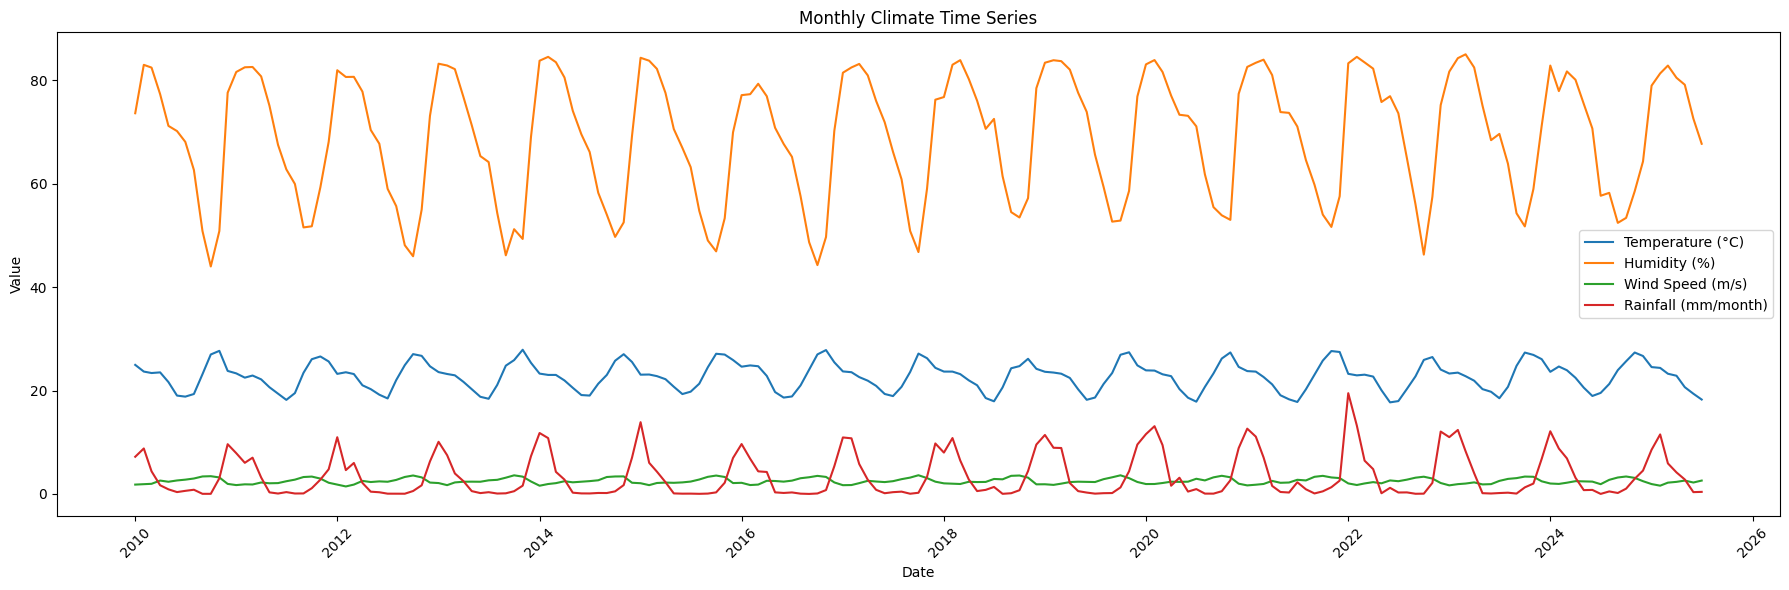

In [27]:
plt.figure(figsize=(18,6))
plt.plot(monthly_climate['date'], monthly_climate['Temperature'], label='Temperature (°C)')
plt.plot(monthly_climate['date'], monthly_climate['Humidity'], label='Humidity (%)')
plt.plot(monthly_climate['date'], monthly_climate['WindSpeed'], label='Wind Speed (m/s)')
plt.plot(monthly_climate['date'], monthly_climate['Rainfall'], label='Rainfall (mm/month)')

plt.title('Monthly Climate Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("climate-variables.png", dpi=300, bbox_inches='tight')
plt.show()

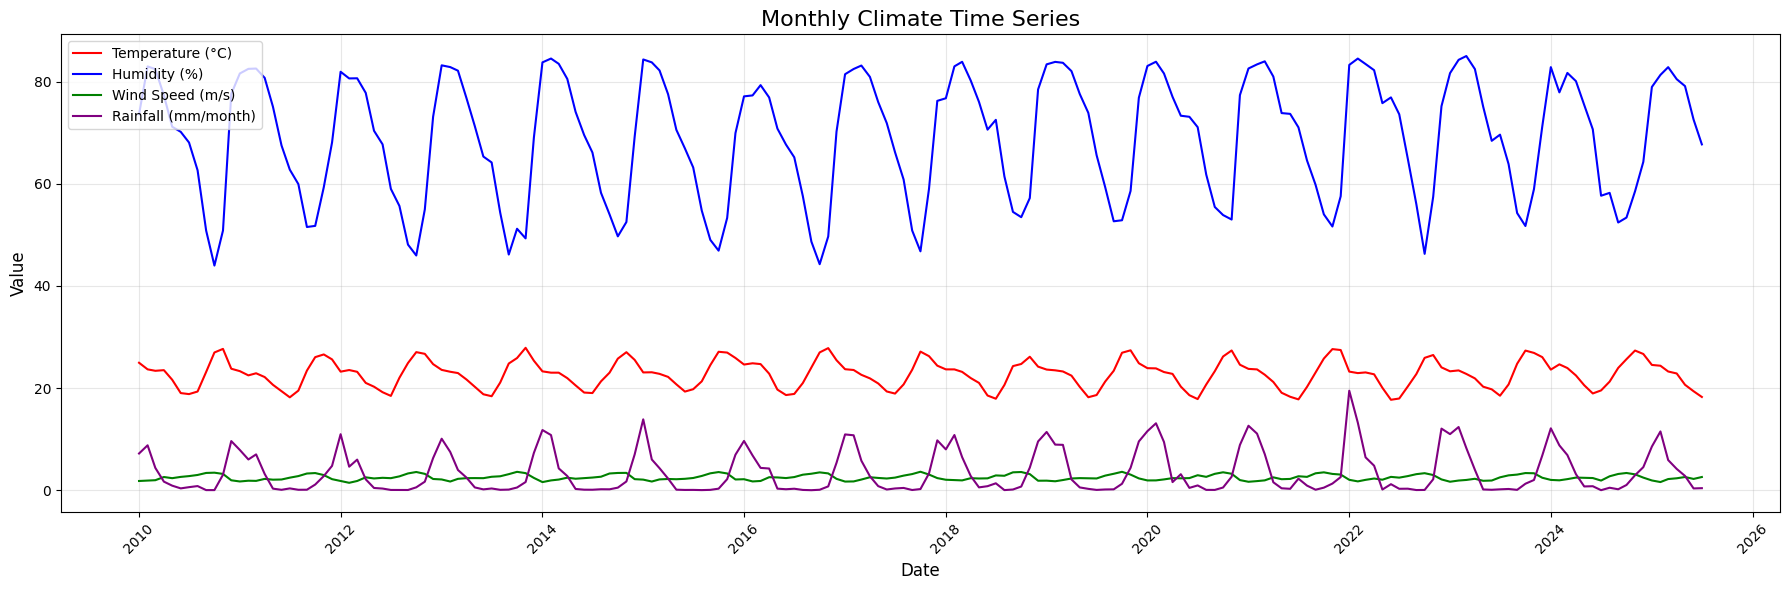

In [30]:
plt.figure(figsize=(18,6))

# Plot all climate variables
plt.plot(monthly_climate['date'], monthly_climate['Temperature'], label='Temperature (°C)', color='red')
plt.plot(monthly_climate['date'], monthly_climate['Humidity'], label='Humidity (%)', color='blue')
plt.plot(monthly_climate['date'], monthly_climate['WindSpeed'], label='Wind Speed (m/s)', color='green')
plt.plot(monthly_climate['date'], monthly_climate['Rainfall'], label='Rainfall (mm/month)', color='purple')

# Titles and labels
plt.title('Monthly Climate Time Series', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Legend and x-axis formatting
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# Layout and save
plt.tight_layout()
plt.savefig("climate-months.png", dpi=300, bbox_inches='tight')
plt.show()

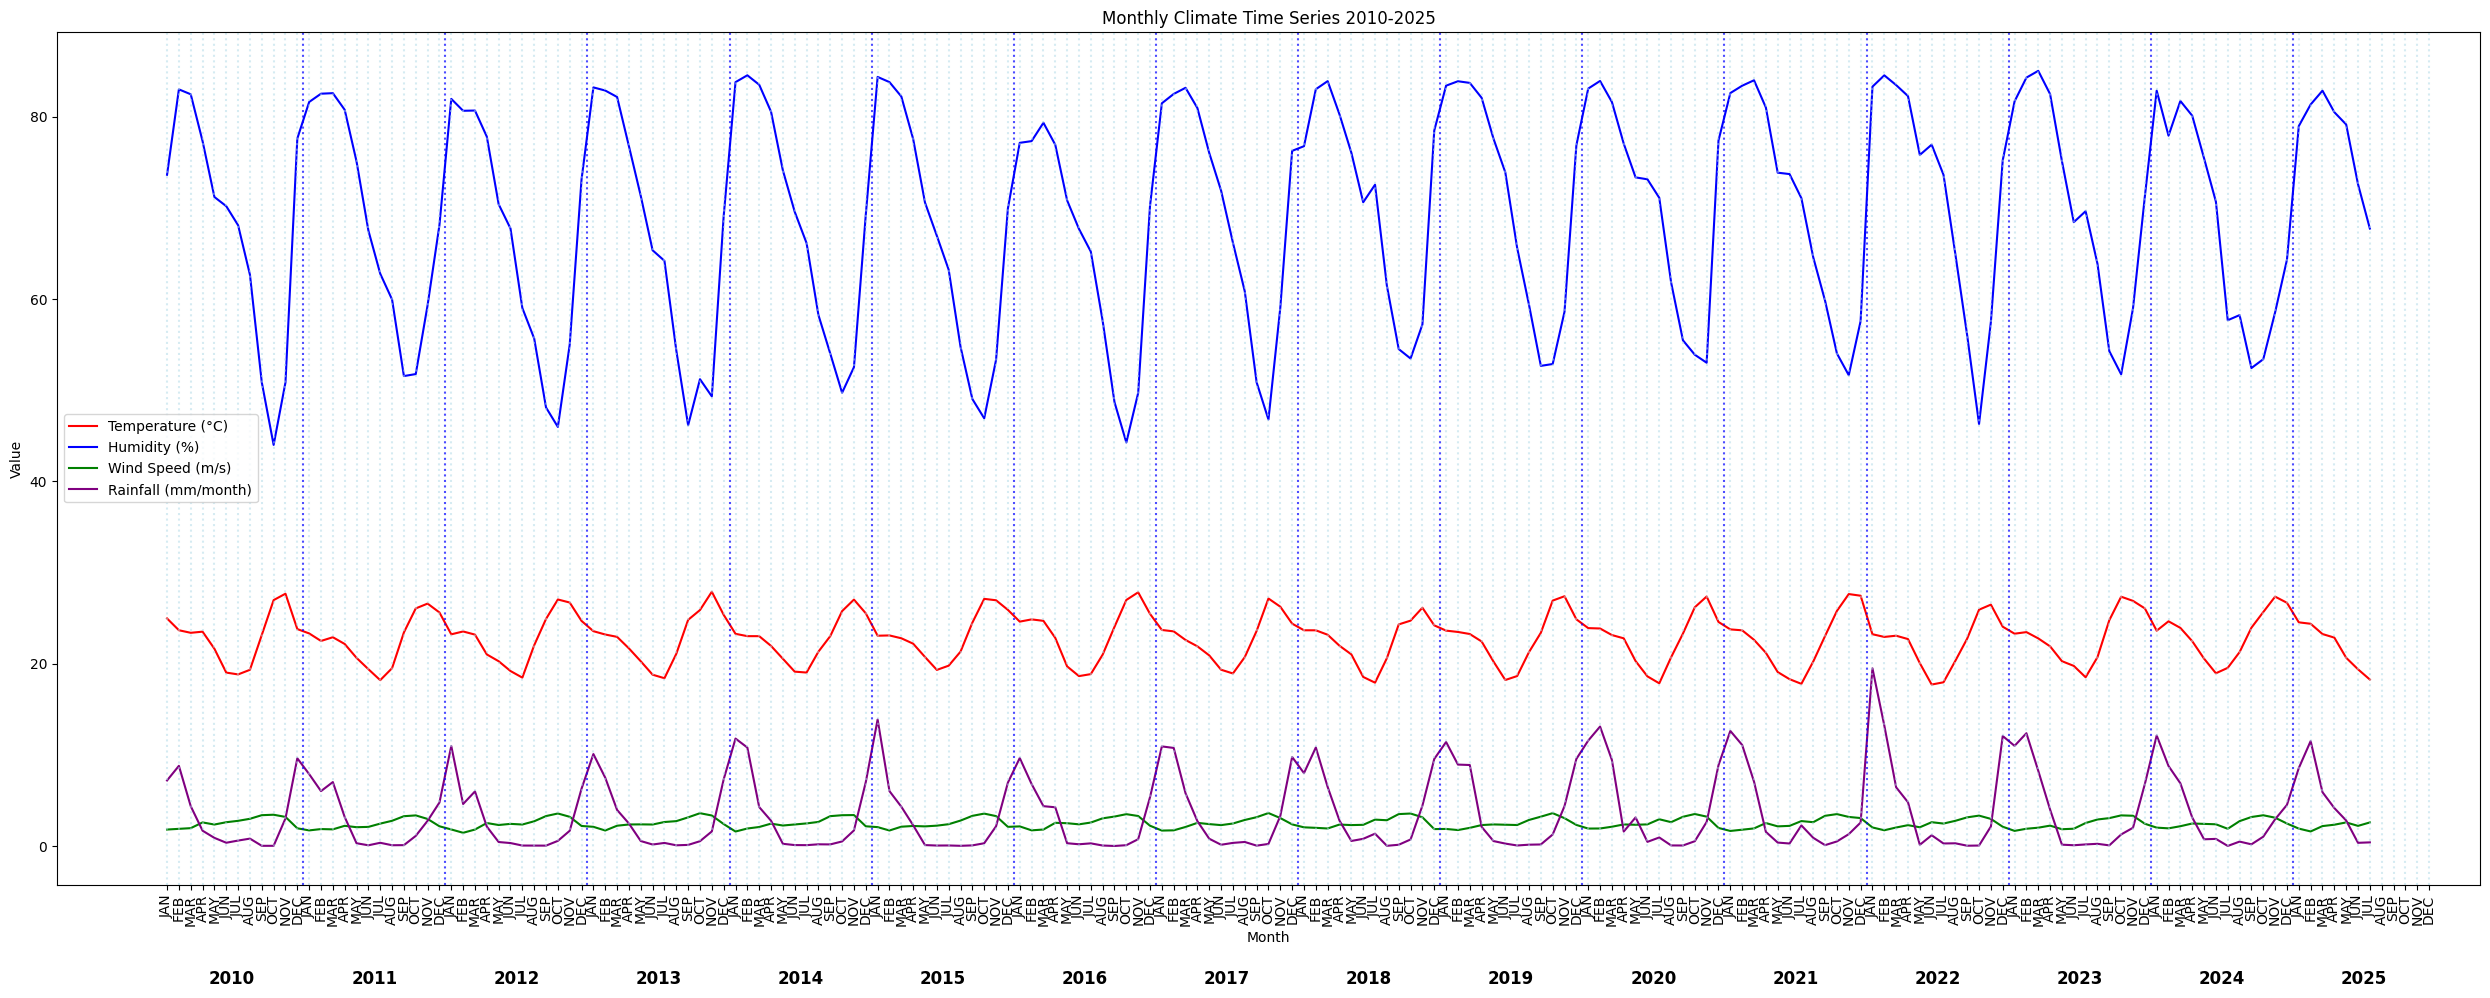

In [31]:

# --- Melt function ---
def melt_monthly(df, value_name):
    # Drop PARAMETER columns if present to avoid merge conflicts
    df = df.drop(columns=[c for c in df.columns if c.startswith("PARAMETER")], errors='ignore')
    return df.melt(
        id_vars=['YEAR','LAT','LON'],
        value_vars=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],
        var_name='Month',
        value_name=value_name
    )

# --- Reshape datasets ---
temp_long = melt_monthly(df_Temp, 'Temperature')
humidity_long = melt_monthly(df_Hum, 'Humidity')
wind_long = melt_monthly(df_Wind, 'WindSpeed')
rain_long = melt_monthly(df_rain, 'Rainfall')

# --- Merge datasets ---
climate = temp_long.merge(humidity_long, on=['YEAR','LAT','LON','Month'])
climate = climate.merge(wind_long, on=['YEAR','LAT','LON','Month'])
climate = climate.merge(rain_long, on=['YEAR','LAT','LON','Month'])

# --- Map month abbreviations to numbers ---
month_map = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,
             'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}
climate['Month_Num'] = climate['Month'].map(month_map)

# --- Aggregate across locations ---
monthly_climate = climate.groupby(['YEAR','Month_Num','Month']).mean(numeric_only=True).reset_index()
monthly_climate = monthly_climate.sort_values(['YEAR','Month_Num']).reset_index(drop=True)

# --- Create x positions ---
x = range(len(monthly_climate))
months = monthly_climate['Month']
years = monthly_climate['YEAR']

# --- Plot ---
plt.figure(figsize=(25,10))
plt.plot(x, monthly_climate['Temperature'], label='Temperature (°C)', color='red')
plt.plot(x, monthly_climate['Humidity'], label='Humidity (%)', color='blue')
plt.plot(x, monthly_climate['WindSpeed'], label='Wind Speed (m/s)', color='green')
plt.plot(x, monthly_climate['Rainfall'], label='Rainfall (mm/month)', color='purple')

# --- Month labels ---
plt.xticks(x, months, rotation=90)

# --- Vertical dotted lines for each month ---
for xi in x:
    plt.axvline(xi, color='lightblue', linestyle='dotted', alpha=0.5)

# --- Year brackets & vertical lines ---
ax = plt.gca()
year_positions = {}
for i, y in enumerate(years):
    if y not in year_positions:
        year_positions[y] = [i, i]
    else:
        year_positions[y][1] = i

for y, (start, end) in year_positions.items():
    # Place year text below x-axis
    ax.text(
        (start + end)/2, -0.1,
        str(y),
        ha='center', va='top',
        fontsize=12,
        fontweight='bold',
        transform=ax.get_xaxis_transform()
    )

    if start != 0:
        ax.axvline(start-0.5, color='blue', linestyle='dotted', alpha=0.7)

# --- Titles, labels, legend, layout ---
plt.title('Monthly Climate Time Series 2010-2025')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.savefig('Climate_monthly.png', dpi=300, bbox_inches='tight')
plt.show()


In [37]:
df_climate_incidence = pd.merge(monthly_climate, df_merged_incidence, on=['YEAR', 'Month_Num'], how='inner')

In [39]:
# Select climate variables + OPD
variables = ['Temperature', 'Humidity', 'WindSpeed', 'Rainfall', 'NMCP OPD Confirmed Malaria Cases']

# Compute correlation matrix
corr_matrix = df_climate_incidence[variables].corr()
print(corr_matrix)

# Correlation of OPD with each climate variable
corr_with_opd = corr_matrix['NMCP OPD Confirmed Malaria Cases'].drop('NMCP OPD Confirmed Malaria Cases')
print("Correlation with OPD incidence:")
print(corr_with_opd)


                                  Temperature  Humidity  WindSpeed  Rainfall  \
Temperature                          1.000000 -0.307405   0.307678  0.317029   
Humidity                            -0.307405  1.000000  -0.879189  0.649540   
WindSpeed                            0.307678 -0.879189   1.000000 -0.638455   
Rainfall                             0.317029  0.649540  -0.638455  1.000000   
NMCP OPD Confirmed Malaria Cases     0.004288  0.066956  -0.061299  0.045233   

                                  NMCP OPD Confirmed Malaria Cases  
Temperature                                               0.004288  
Humidity                                                  0.066956  
WindSpeed                                                -0.061299  
Rainfall                                                  0.045233  
NMCP OPD Confirmed Malaria Cases                          1.000000  
Correlation with OPD incidence:
Temperature    0.004288
Humidity       0.066956
WindSpeed     -0.061299
R

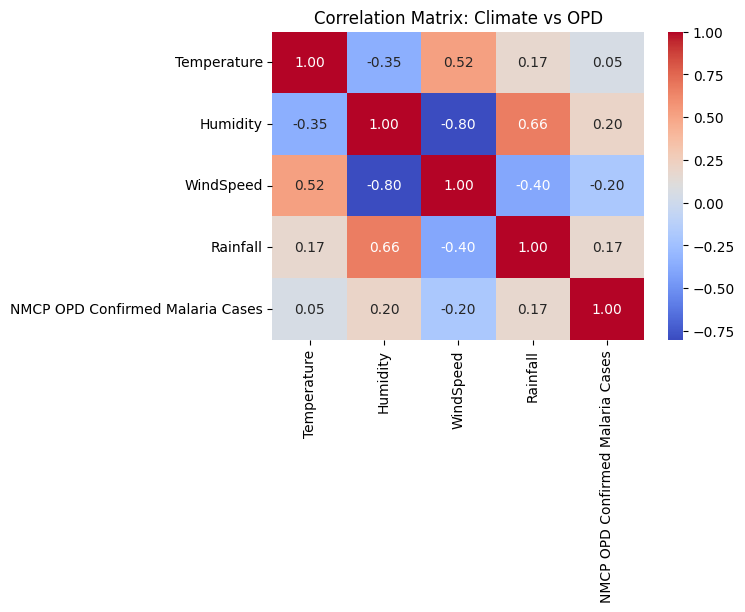

In [77]:
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Climate vs OPD')
plt.savefig('Climate_incidence correlation_overall.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
from scipy.stats import pearsonr

for var in ['Temperature', 'Humidity', 'WindSpeed', 'Rainfall']:
    r, p = pearsonr(df_climate_incidence[var], df_climate_incidence['NMCP OPD Confirmed Malaria Cases'])
    print(f"{var} vs OPD: r={r:.2f}, p={p:.3f}")


Temperature vs OPD: r=nan, p=nan
Humidity vs OPD: r=nan, p=nan
WindSpeed vs OPD: r=nan, p=nan
Rainfall vs OPD: r=nan, p=nan


In [45]:
# Check for missing values in each column
print(df_climate_incidence[['Temperature','Humidity','WindSpeed','Rainfall','NMCP OPD Confirmed Malaria Cases']].isna().sum())


Temperature                             0
Humidity                                0
WindSpeed                               0
Rainfall                                0
NMCP OPD Confirmed Malaria Cases    27993
dtype: int64


In [47]:
print(df_climate_incidence[['Temperature','Humidity','WindSpeed','Rainfall','NMCP OPD Confirmed Malaria Cases']].dtypes)


Temperature                         float64
Humidity                            float64
WindSpeed                           float64
Rainfall                            float64
NMCP OPD Confirmed Malaria Cases    float64
dtype: object


In [48]:
df_clean = df_climate_incidence[['Temperature','Humidity','WindSpeed','Rainfall','NMCP OPD Confirmed Malaria Cases']].dropna()

In [49]:
from scipy.stats import pearsonr

for var in ['Temperature','Humidity','WindSpeed','Rainfall']:
    r, p = pearsonr(df_clean[var], df_clean['NMCP OPD Confirmed Malaria Cases'])
    print(f"{var} vs OPD: r={r:.2f}, p={p:.3f}")

Temperature vs OPD: r=0.00, p=0.290
Humidity vs OPD: r=0.07, p=0.000
WindSpeed vs OPD: r=-0.06, p=0.000
Rainfall vs OPD: r=0.05, p=0.000


In [52]:
# Select climate variables + OPD
variables = ['Temperature', 'Humidity', 'WindSpeed', 'Rainfall', 'NMCP OPD Confirmed Malaria Cases']

# Compute correlation matrix
corr_matrix = df_clean[variables].corr()
print(corr_matrix)

# Correlation of OPD with each climate variable
corr_with_opd = corr_matrix['NMCP OPD Confirmed Malaria Cases'].drop('NMCP OPD Confirmed Malaria Cases')
print("Correlation with OPD incidence:")
print(corr_with_opd)


                                  Temperature  Humidity  WindSpeed  Rainfall  \
Temperature                          1.000000 -0.309512   0.321903  0.316642   
Humidity                            -0.309512  1.000000  -0.864739  0.648241   
WindSpeed                            0.321903 -0.864739   1.000000 -0.630149   
Rainfall                             0.316642  0.648241  -0.630149  1.000000   
NMCP OPD Confirmed Malaria Cases     0.004288  0.066956  -0.061299  0.045233   

                                  NMCP OPD Confirmed Malaria Cases  
Temperature                                               0.004288  
Humidity                                                  0.066956  
WindSpeed                                                -0.061299  
Rainfall                                                  0.045233  
NMCP OPD Confirmed Malaria Cases                          1.000000  
Correlation with OPD incidence:
Temperature    0.004288
Humidity       0.066956
WindSpeed     -0.061299
R

In [54]:
# Mapping the climate variables to specific districts and doing the same for incidence data by splitting the column of orgunitlevel3 into districts

!pip install reverse_geocoder

In [56]:
import reverse_geocoder as rg

coords = list(zip(climate['LAT'], climate['LON']))  # note: reverse_geocoder expects (lat, lon)
results = rg.search(coords)

# Extract district names
climate['District'] = [res['admin2'] for res in results]  # admin1 was regional locations i.e central region/nothern region
print(climate.head())


Loading formatted geocoded file...
   YEAR   LAT     LON Month  Temperature  Humidity  WindSpeed  Rainfall  \
0  2010 -10.0  33.125   JAN        22.15     81.68       1.25      6.96   
1  2010 -10.0  33.750   JAN        23.68     77.24       1.37      6.76   
2  2010 -10.0  34.375   JAN        26.05     68.67       2.19      6.31   
3  2010 -10.0  35.000   JAN        21.18     87.53       0.66      7.94   
4  2010 -10.0  35.625   JAN        22.74     89.02       0.59      9.62   

   Month_Num          District  
0          1  Chitipa District  
1          1  Karonga District  
2          1                    
3          1                    
4          1                    


In [58]:
# Print unique values in the 'periodname' column
unique_districts = climate['District'].unique()
print(unique_districts)


['Chitipa District' 'Karonga District' '' 'Rumphi District'
 'Mzimba District' 'Nkhata Bay District' 'Likoma District'
 'Kasungu District' 'Nkhotakota District' 'Mchinji District'
 'Dowa District' 'Salima District' 'Lilongwe District' 'Mangochi District'
 'Dedza District' 'Ntcheu District' 'Balaka District' 'Machinga District'
 'Mwanza District' 'Chiradzulu District' 'Phalombe District'
 'Thyolo District' 'Mulanje District' 'Chikwawa District'
 'Nsanje District']


In [61]:
df_merged_incidence['District_Name'] = df_merged_incidence['orgunitlevel3'].str.split('-').str[0]
print(df_merged_incidence[['orgunitlevel3', 'District_Name']].head())

  orgunitlevel3 District_Name
0  Lilongwe-DHO      Lilongwe
1  Lilongwe-DHO      Lilongwe
2  Lilongwe-DHO      Lilongwe
3  Lilongwe-DHO      Lilongwe
4  Lilongwe-DHO      Lilongwe


In [64]:
climate['District_Name'] = climate['District'].str.split(' ').str[0]
print(climate[['District', 'District_Name']].head())

           District District_Name
0  Chitipa District       Chitipa
1  Karonga District       Karonga
2                                
3                                
4                                


In [68]:
# sum OPD cases per district per month
opd_district = df_merged_incidence.groupby(['District_Name','YEAR','Month_Num'])['NMCP OPD Confirmed Malaria Cases'].sum().reset_index()

In [69]:
climate_district = climate.groupby(['District_Name','YEAR','Month_Num'])[['Temperature','Humidity','WindSpeed','Rainfall']].mean().reset_index()

In [70]:
# Merging climate and OPD data at district level
df_merged_district = pd.merge(climate_district, opd_district, on=['District_Name','YEAR','Month_Num'])


In [72]:
from scipy.stats import pearsonr

for var in ['Temperature','Humidity','WindSpeed','Rainfall']:
    r, p = pearsonr(df_merged_district[var], df_merged_district['NMCP OPD Confirmed Malaria Cases'])
    print(f"{var} vs OPD: r={r:.2f}, p={p:.3f}")


Temperature vs OPD: r=-0.07, p=0.000
Humidity vs OPD: r=0.20, p=0.000
WindSpeed vs OPD: r=-0.09, p=0.000
Rainfall vs OPD: r=0.13, p=0.000


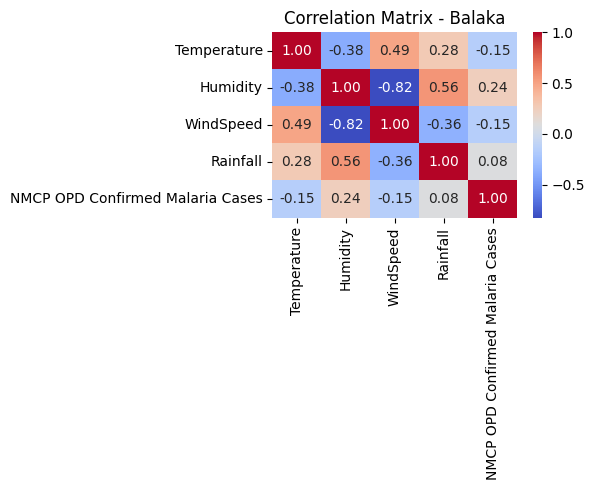

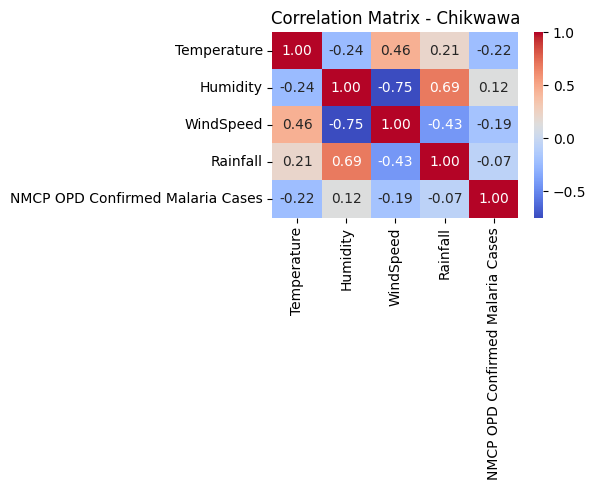

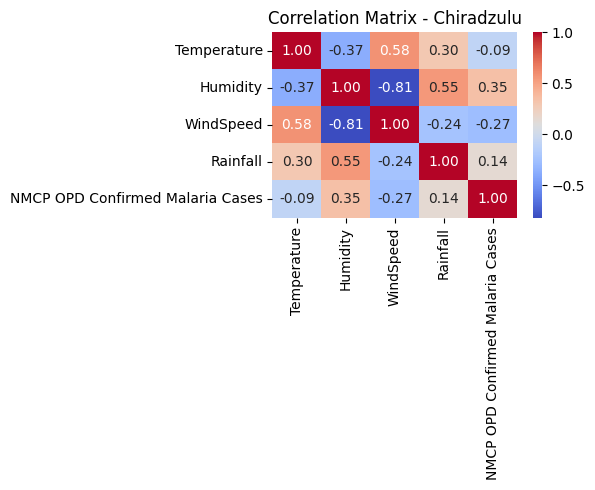

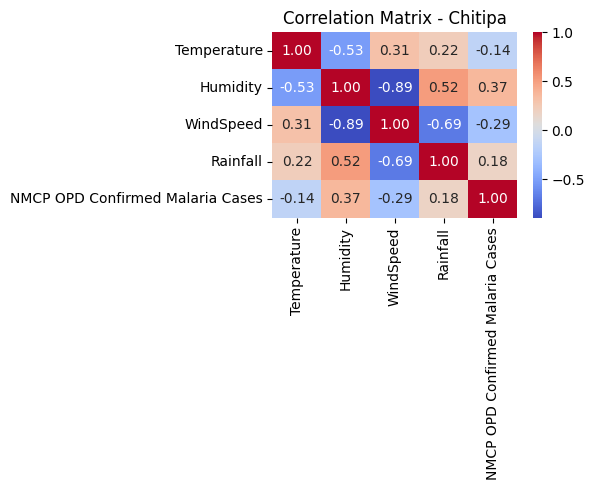

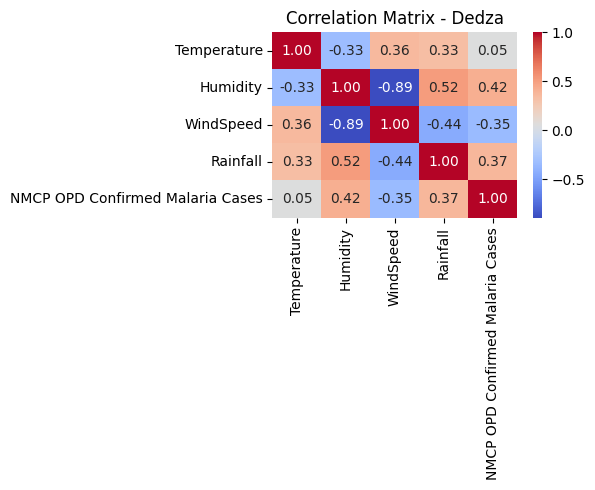

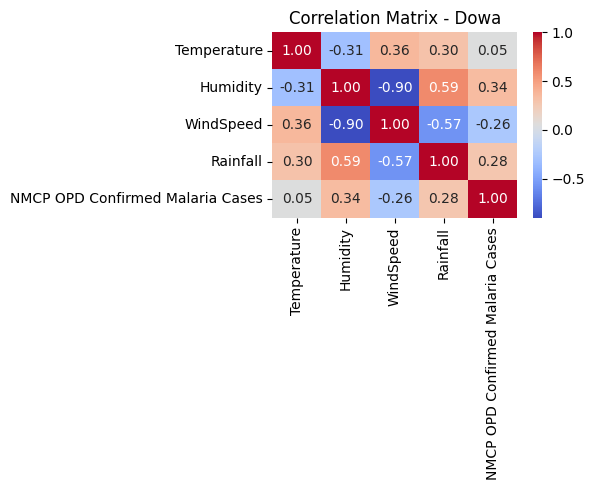

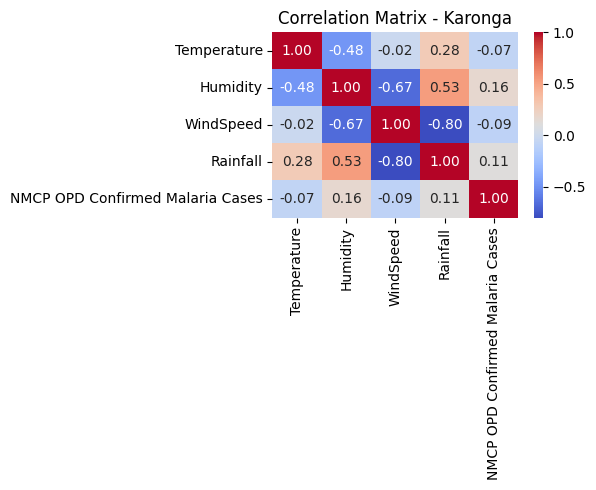

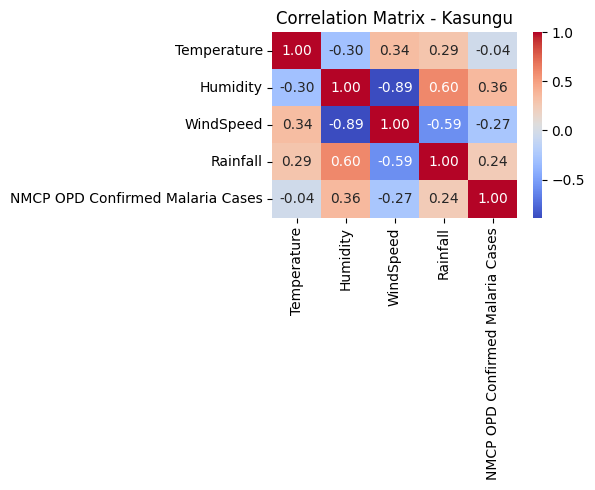

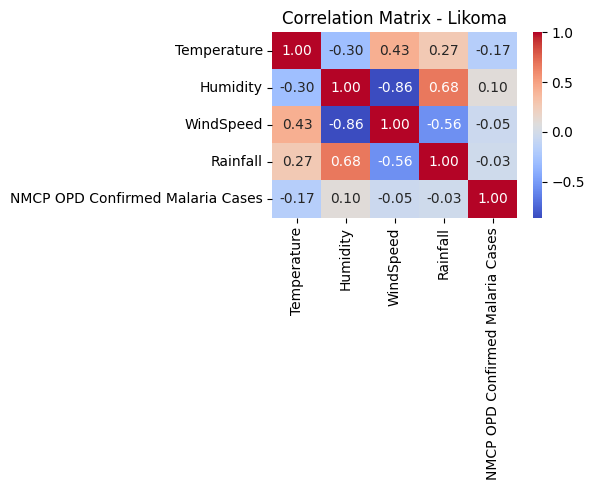

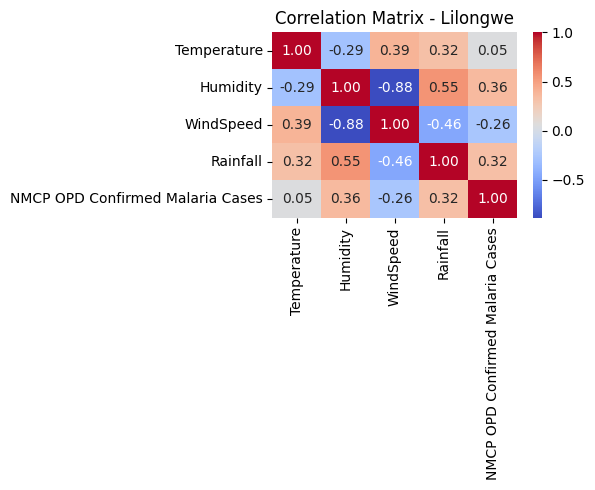

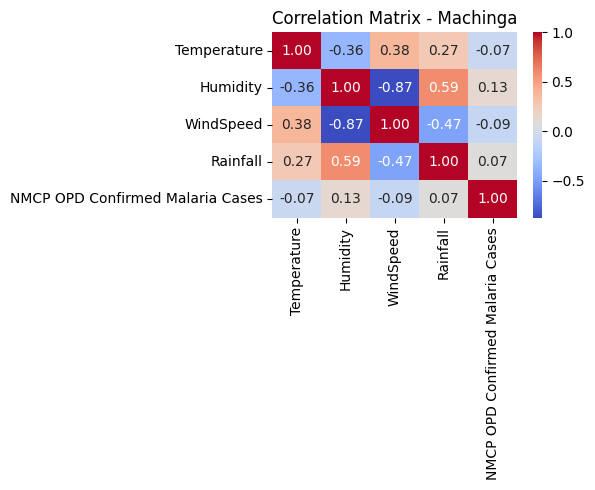

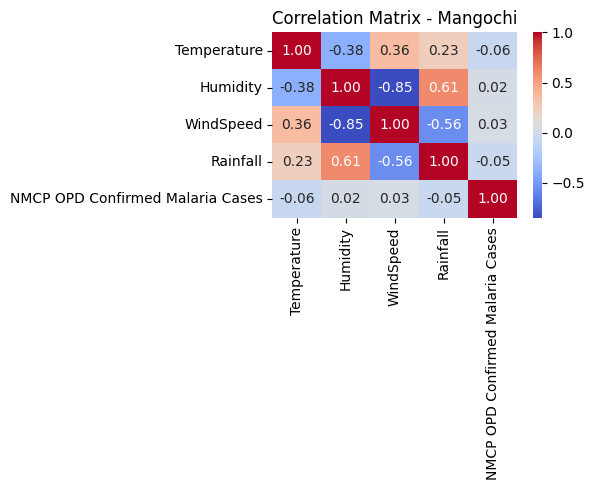

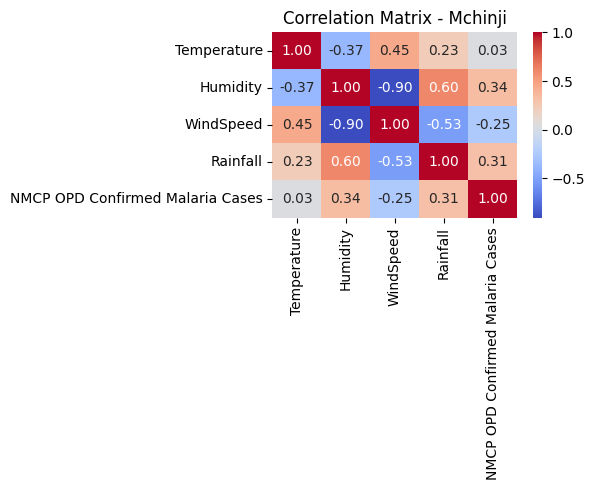

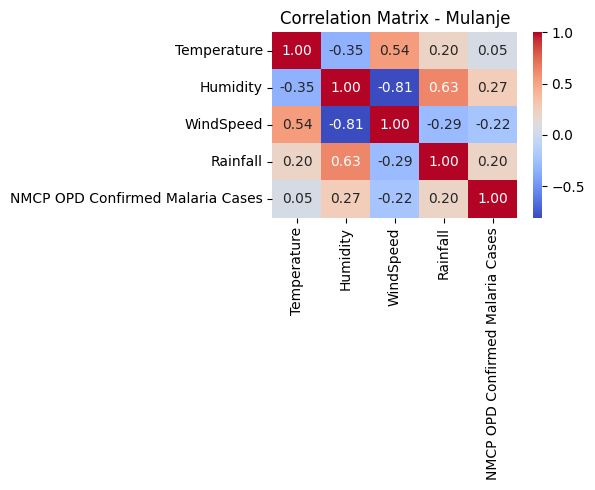

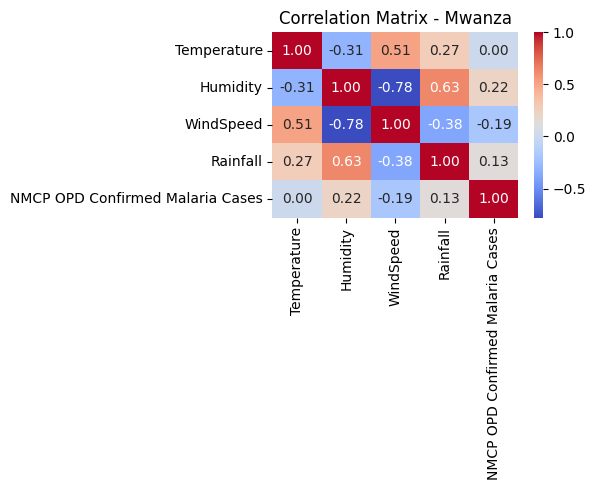

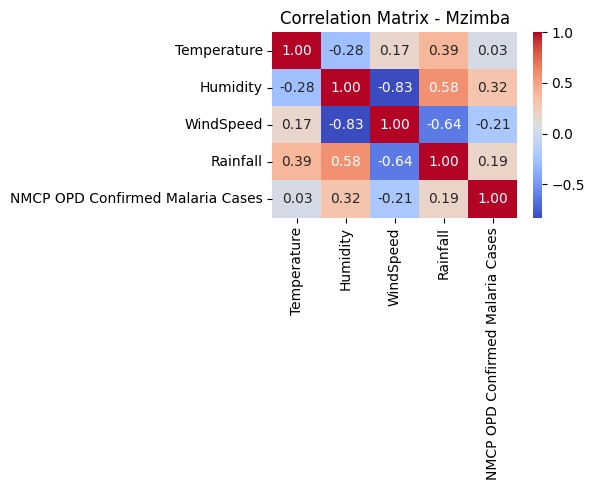

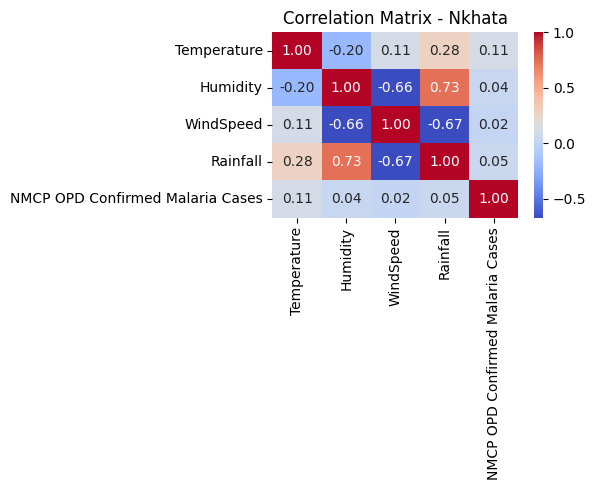

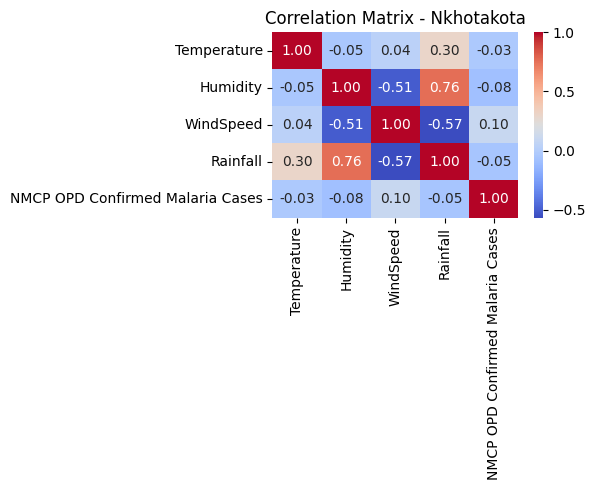

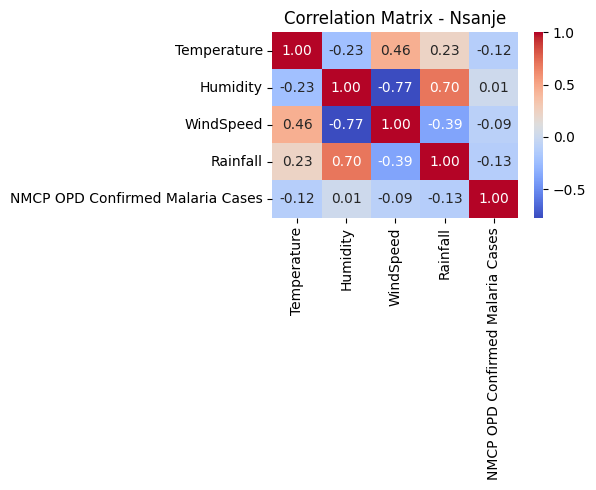

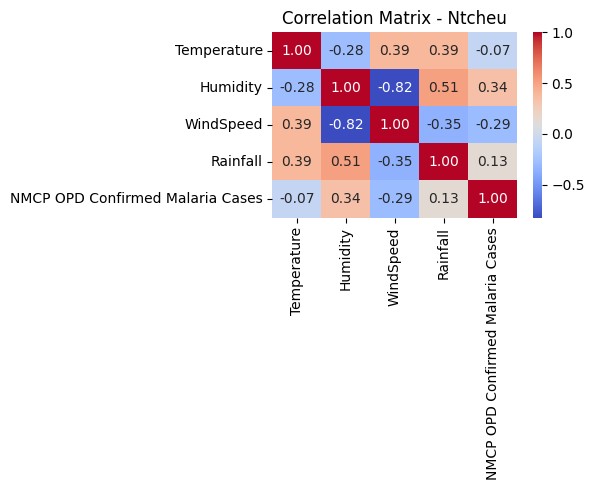

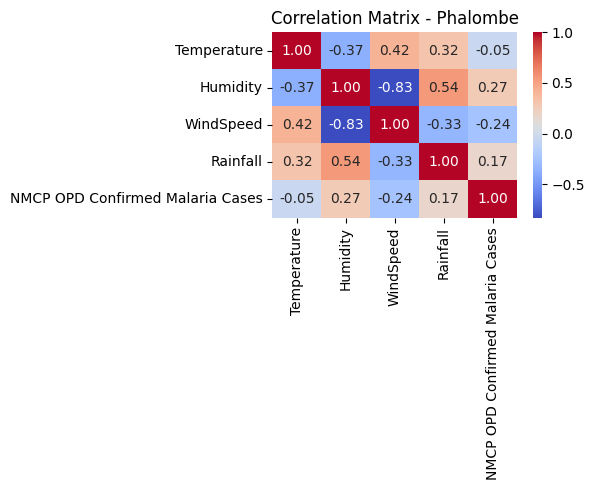

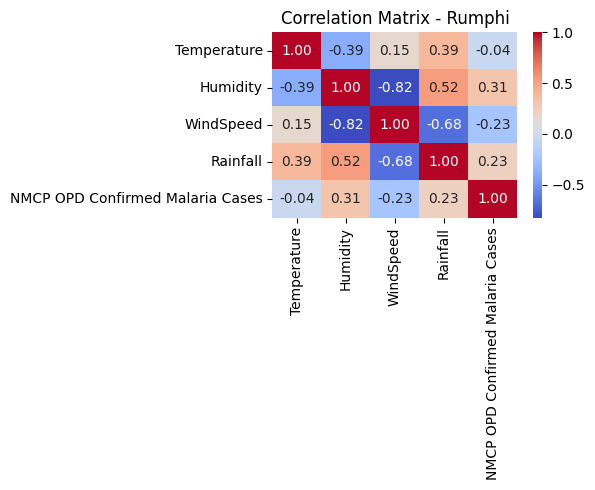

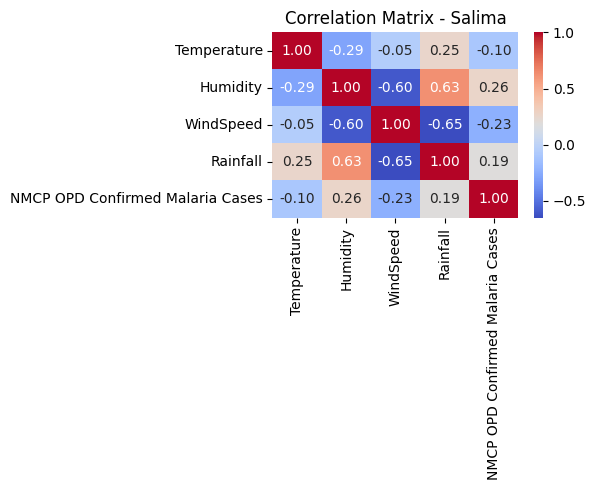

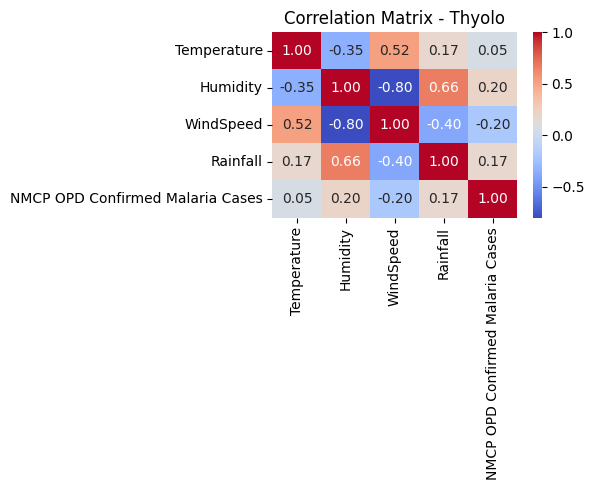

In [76]:
# List of climate variables
climate_vars = ['Temperature','Humidity','WindSpeed','Rainfall','NMCP OPD Confirmed Malaria Cases']

# Get unique districts
districts = df_merged_district['District_Name'].unique()

# Create a dictionary to store correlation matrices
corr_dict = {}

for d in districts:
    df_dist = df_merged_district[df_merged_district['District_Name'] == d][climate_vars].dropna()
    
    # Compute correlation matrix
    corr_matrix = df_dist.corr()
    corr_dict[d] = corr_matrix
    
    # Plot heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix - {d.capitalize()}')
    plt.tight_layout()
    plt.savefig('Climate_incidence_correlation_districts.png', dpi=300, bbox_inches='tight')
    plt.show()


In [79]:
# Plotting and saving each heatmap picture in a folder

import os
# List of climate variables
climate_vars = ['Temperature','Humidity','WindSpeed','Rainfall','NMCP OPD Confirmed Malaria Cases']

# Get unique districts
districts = df_merged_district['District_Name'].unique()

# Create a folder to save heatmaps
output_folder = "district_correlation_heatmaps"
os.makedirs(output_folder, exist_ok=True)

# Dictionary to store correlation matrices
corr_dict = {}

for d in districts:
    # Select data for the district
    df_dist = df_merged_district[df_merged_district['District_Name'] == d][climate_vars].dropna()
    
    # Compute correlation matrix
    corr_matrix = df_dist.corr()
    corr_dict[d] = corr_matrix
    
    # Plot heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix - {d.capitalize()}')
    plt.tight_layout()
    
    # Save the heatmap with district name
    filename = os.path.join(output_folder, f"{d}_correlation.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()  # Close figure to avoid displaying all plots at once


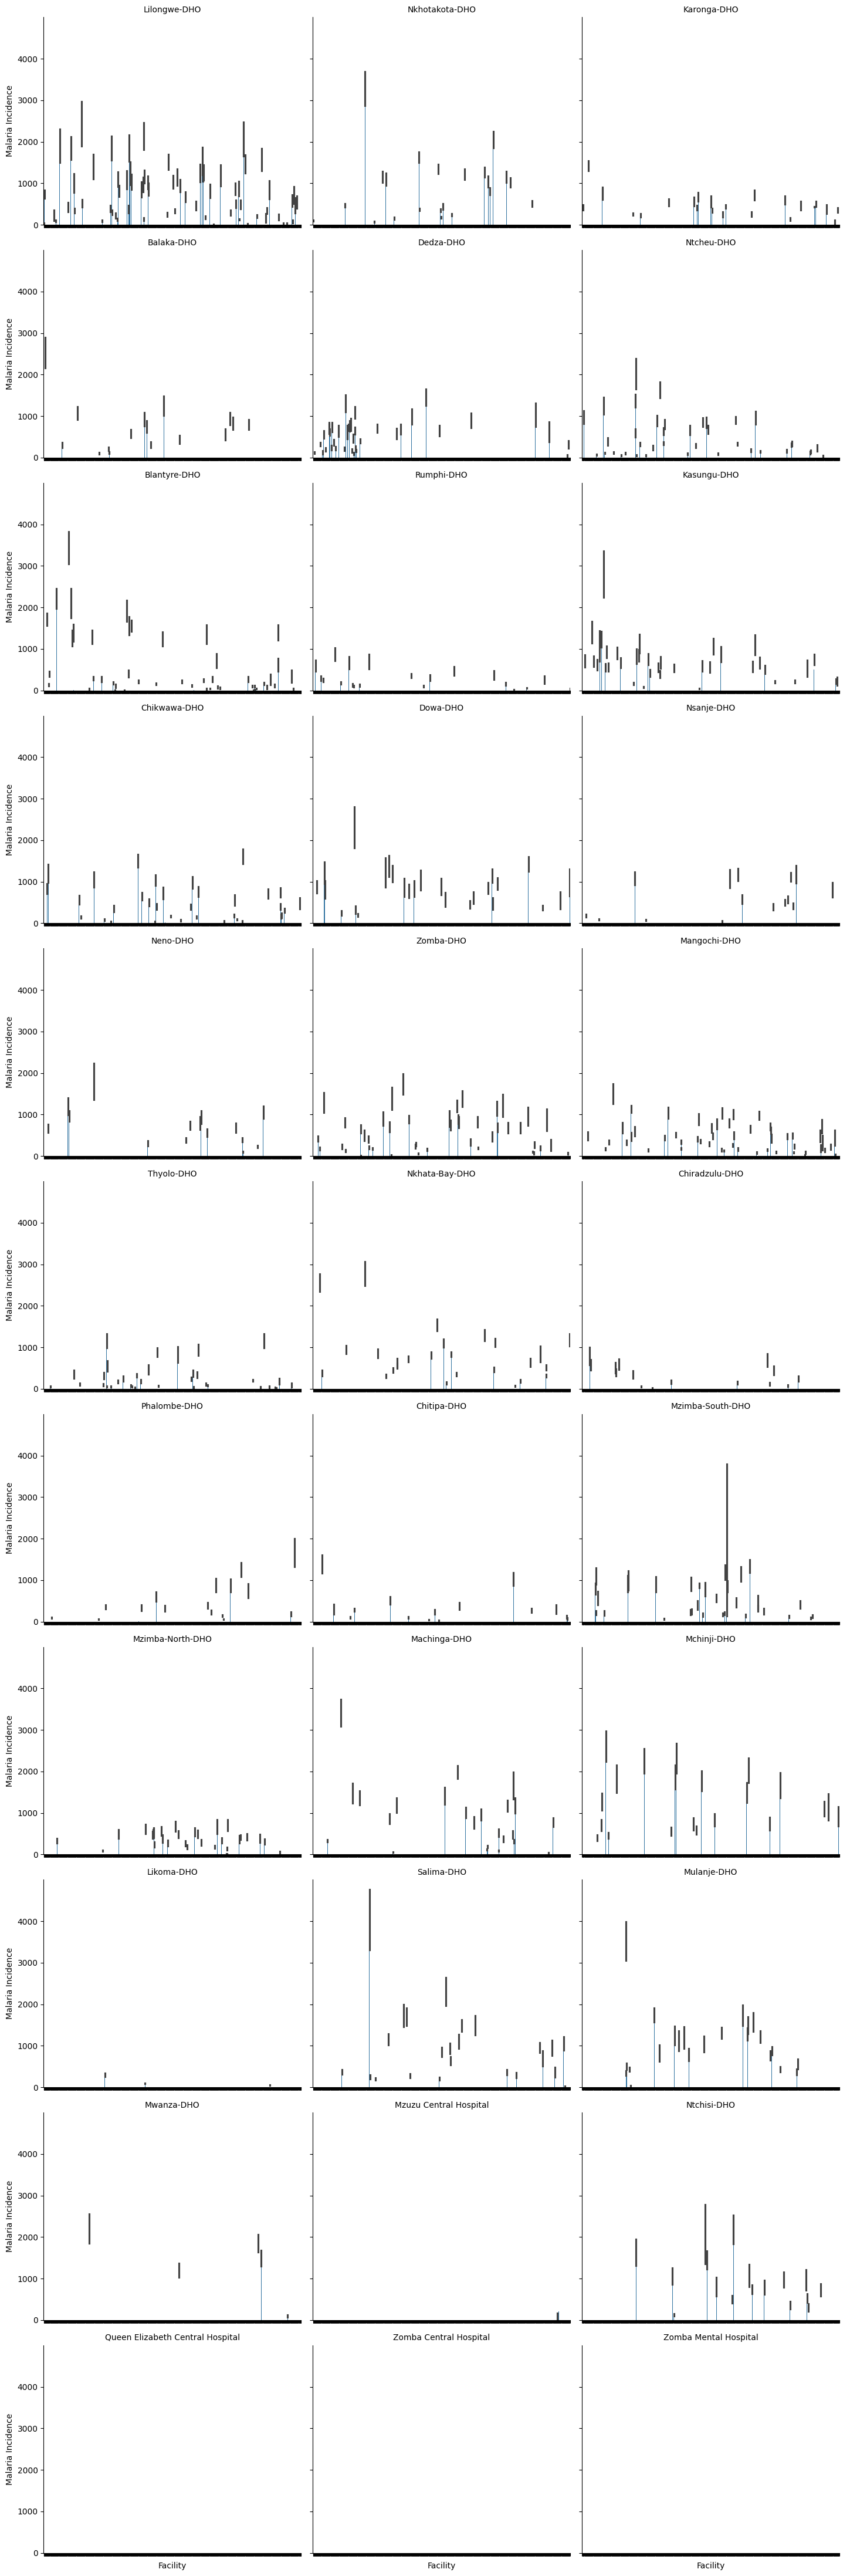

In [17]:
g = sns.catplot(
    data=df_merged_incidence,
    kind="bar",
    x="orgunitlevel4",
    y="NMCP OPD Confirmed Malaria Cases",
    col="orgunitlevel3",   # one subplot per district
    col_wrap=3,            # wrap columns
    height=4,
    aspect=1.2
)

g.set_xticklabels(rotation=90)
g.set_titles("{col_name}")  # show district name
g.set_axis_labels("Facility", "Malaria Incidence")
plt.tight_layout()
plt.show()
